In [2]:
# Libs
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.models import resnet18
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import (
    show_cam_on_image, deprocess_image, preprocess_image
)

In [3]:
class MyImageFolder(datasets.ImageFolder):  
    def __init__(self, root, transform=None, target_transform=None,  
                 loader=datasets.folder.default_loader,  
                 is_valid_file=None):  
        super(MyImageFolder, self).__init__(root, transform, target_transform, loader, is_valid_file)  

    def __getitem__(self, index):  
        sample, target = super(MyImageFolder, self).__getitem__(index)  
        return sample, target, index

In [4]:
# Load data
torch.manual_seed(42)
train_transform = transforms.Compose([
    transforms.ToTensor(),
])

normal_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])

train_transform2 = transforms.Compose([
    transforms.RandomCrop(224, padding=32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])
train_ds = MyImageFolder('mydata/train',
                                transform = train_transform,)
test_ds = datasets.ImageFolder('mydata/test',
                                transform = test_transform,)
batch_size=64
def get_dataloader_workers():
    return 4
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=get_dataloader_workers())
test_dl = DataLoader(test_ds,batch_size=batch_size,shuffle=False,num_workers=get_dataloader_workers())

In [5]:
def displayImg(img):
    npImg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npImg,(1,2,0)))
    plt.show()

tensor(41088)
tensor(8)


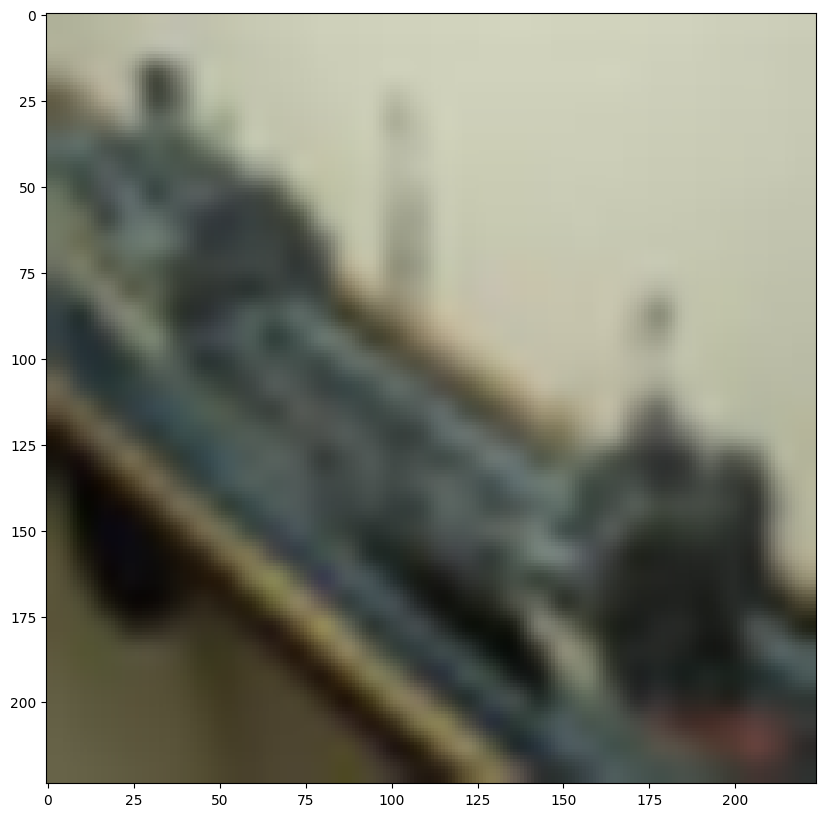

tensor(47912)
tensor(9)


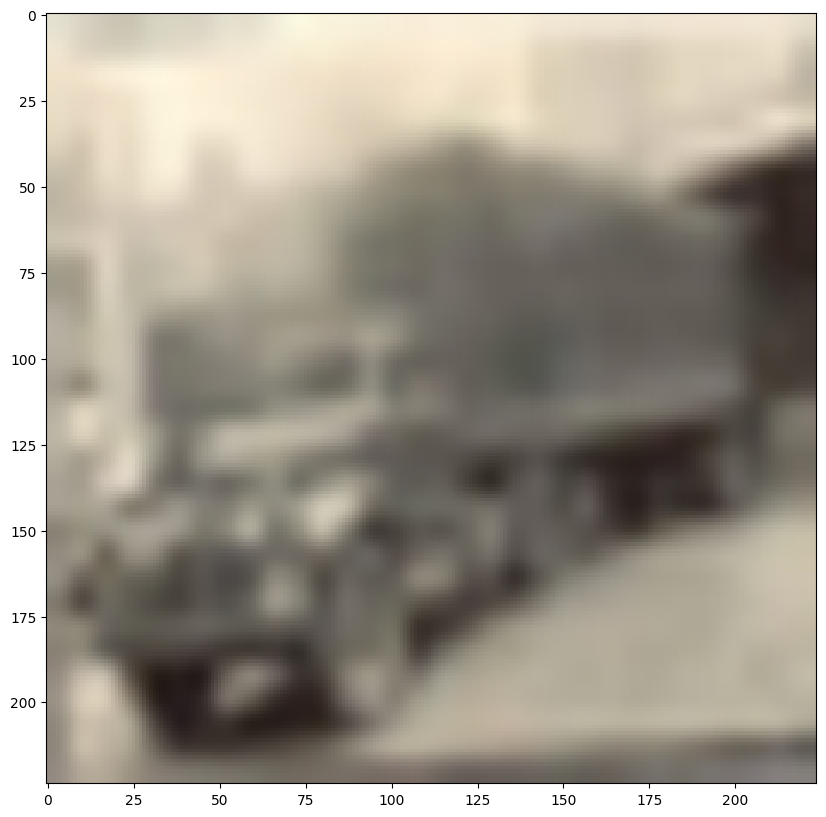

tensor(41033)
tensor(8)


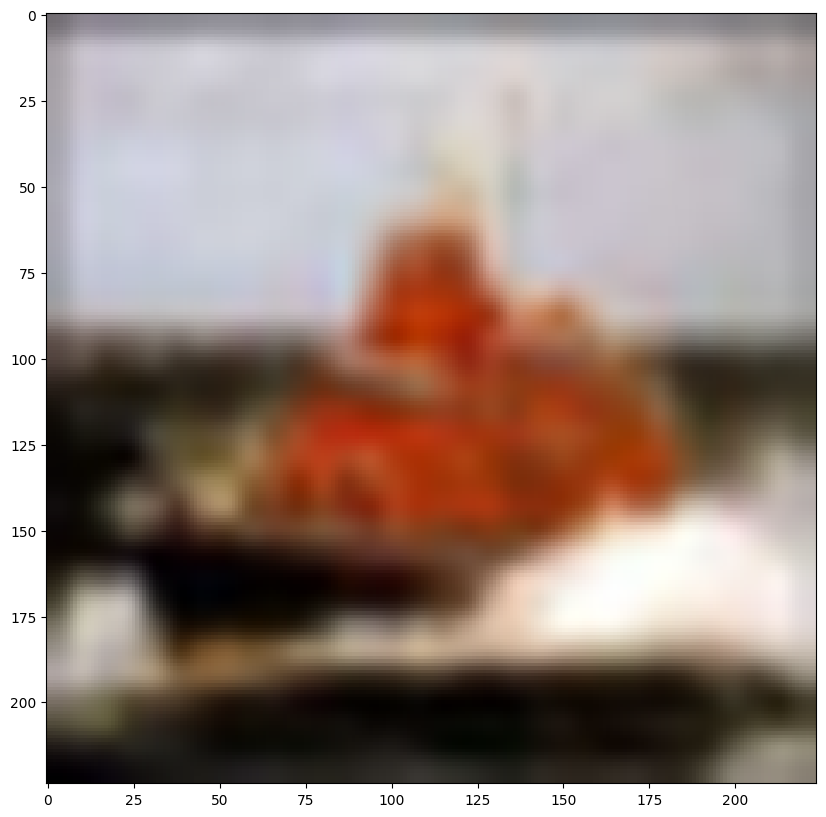

tensor(9267)
tensor(1)


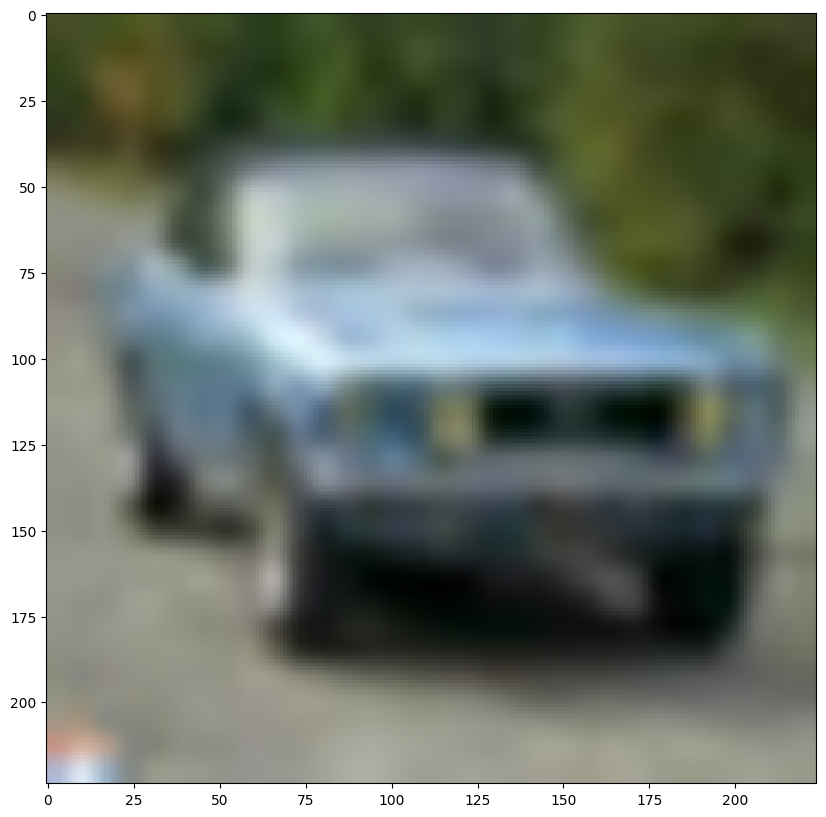

tensor(2702)
tensor(0)


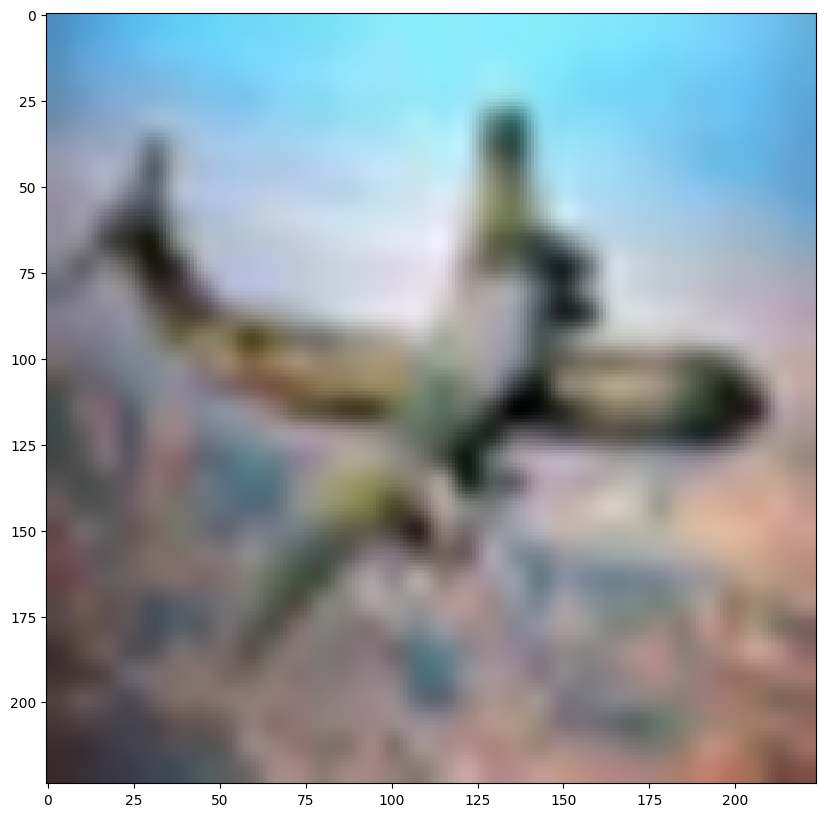

tensor(26895)
tensor(5)


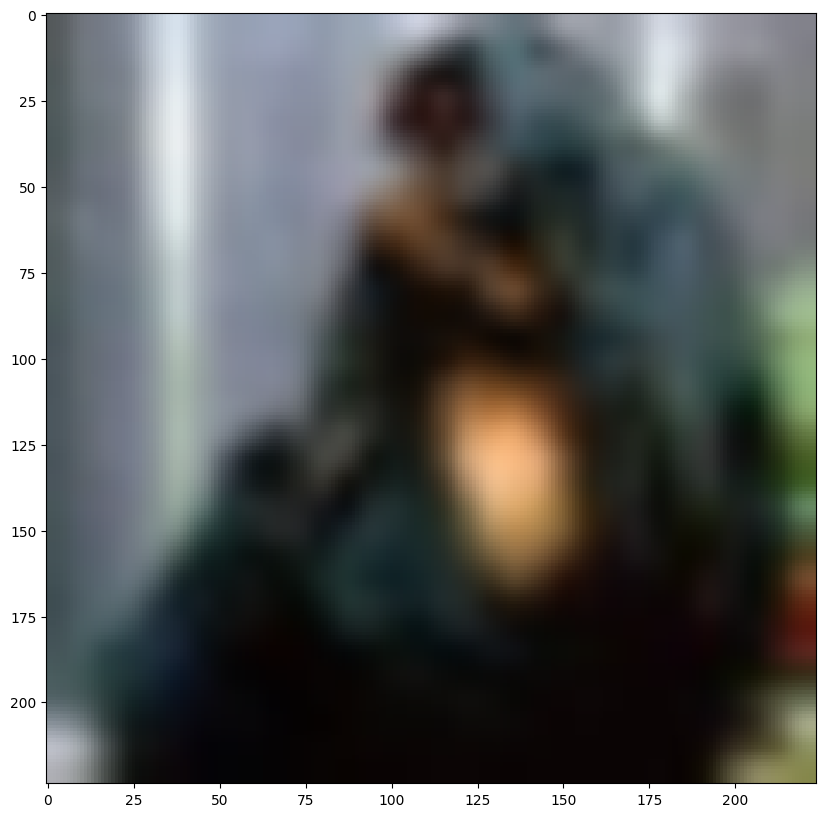

tensor(23580)
tensor(4)


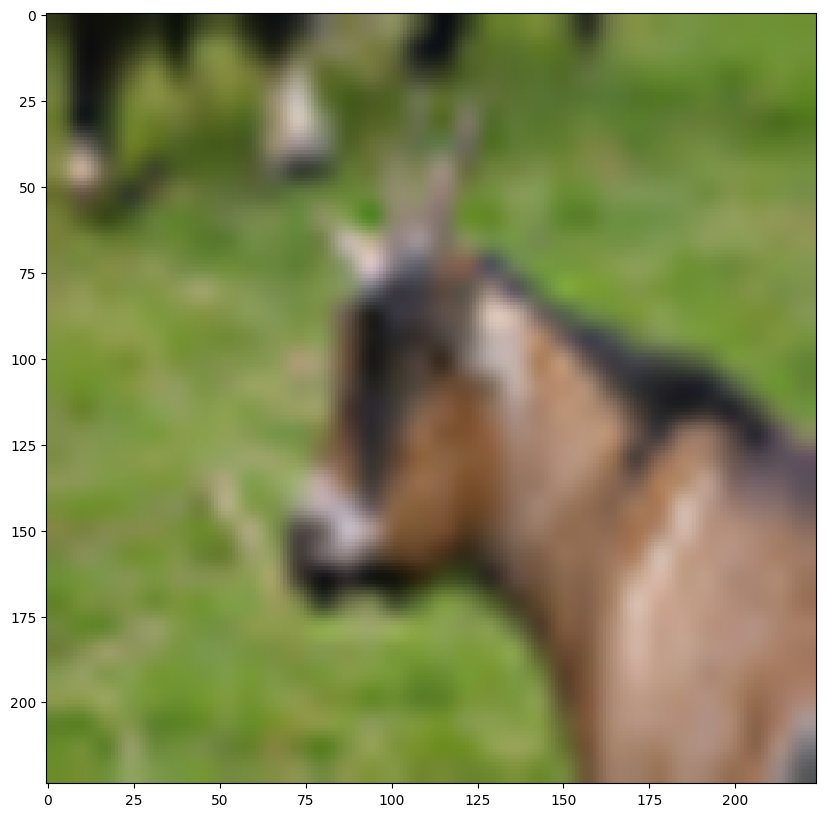

tensor(4043)
tensor(0)


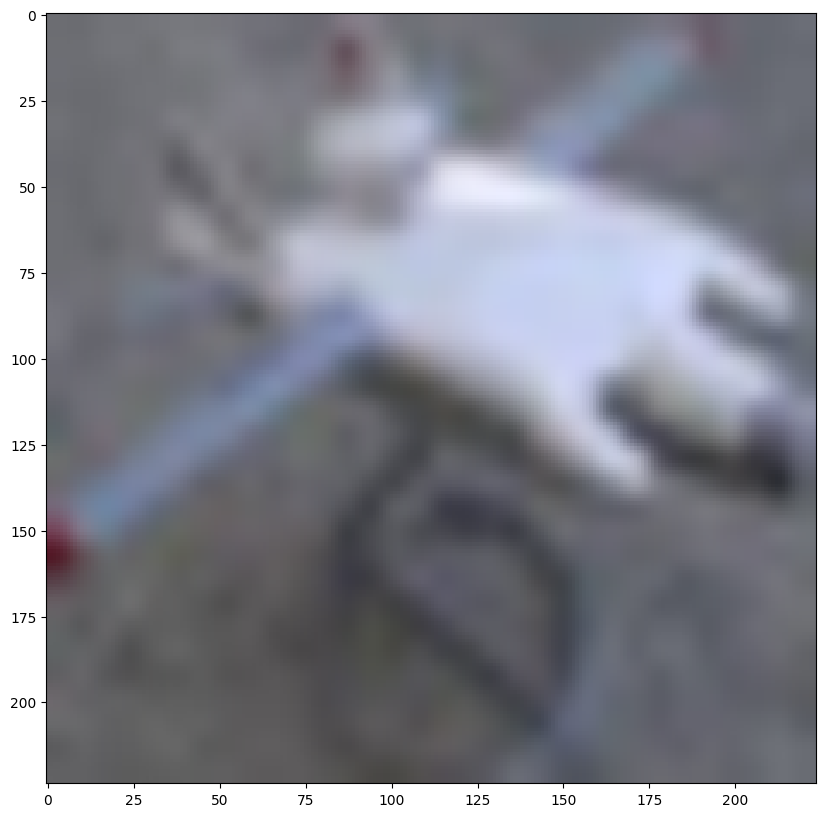

tensor(40579)
tensor(8)


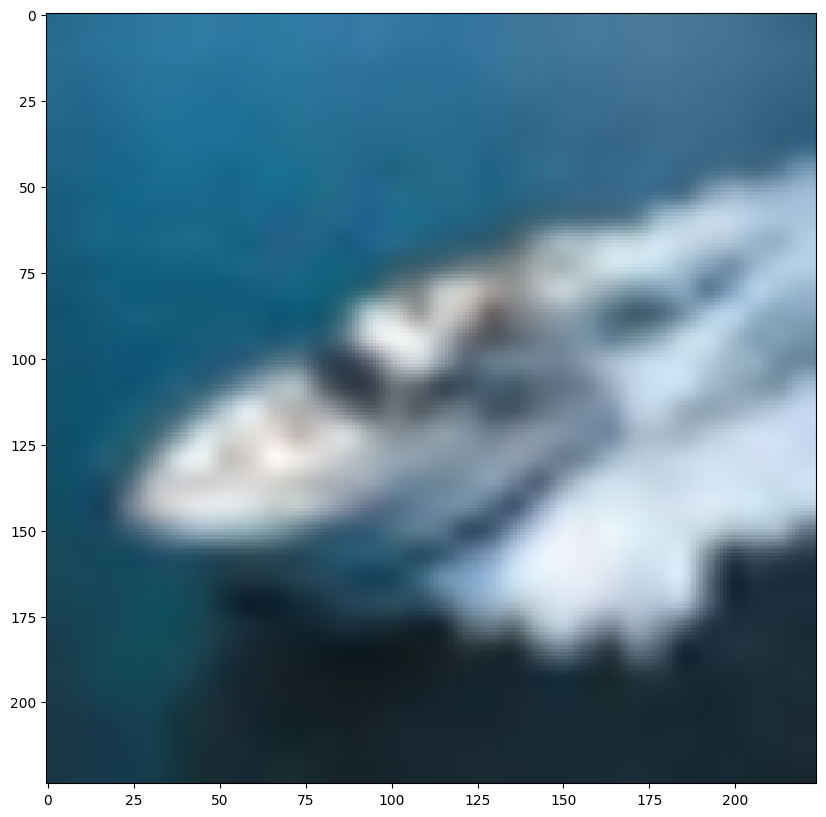

tensor(40132)
tensor(8)


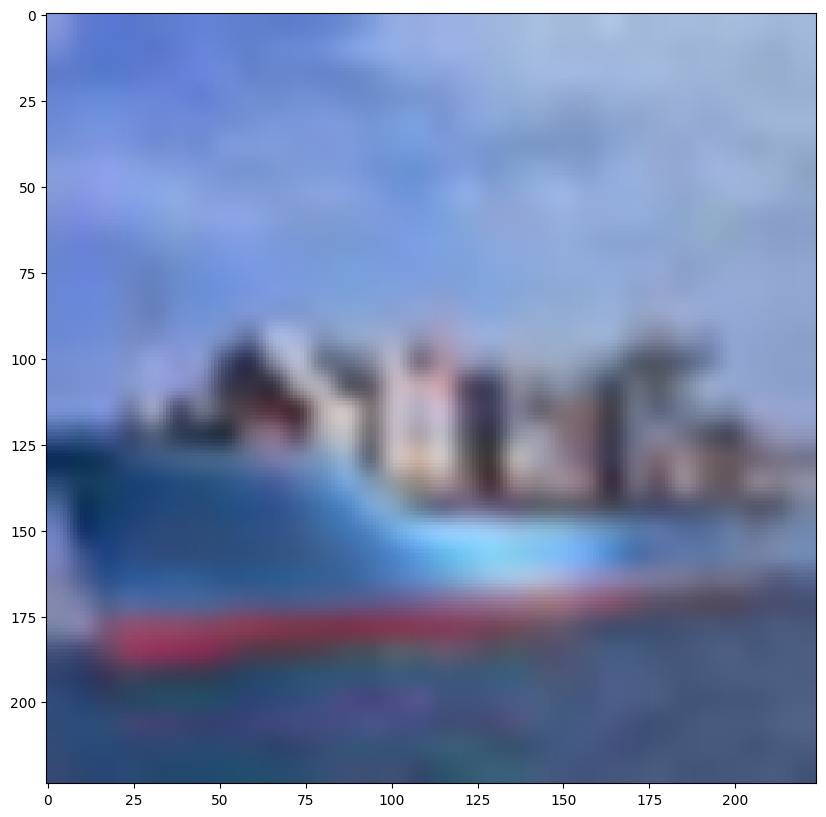

In [6]:
someImages = 0
someLabels = 0
someIndex = 0
i=0
for X,y,index in iter(train_dl):
    someImages=X
    someLabels=y
    someIndex = index
    break

for i in range(0,10):
    print(someIndex[i])
    print(someLabels[i])
    displayImg(someImages[i])

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
model=resnet18(num_classes = 10).to(device)
model.load_state_dict(torch.load('best.pkl'))
model.eval()

Using cuda device


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
#optimizer.load_state_dict(torch.load('optim_data.pkl'))
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=200,eta_min=0.0001,last_epoch=-1)

tensor(44538)
tensor(8, device='cuda:0')
tensor([8], device='cuda:0')


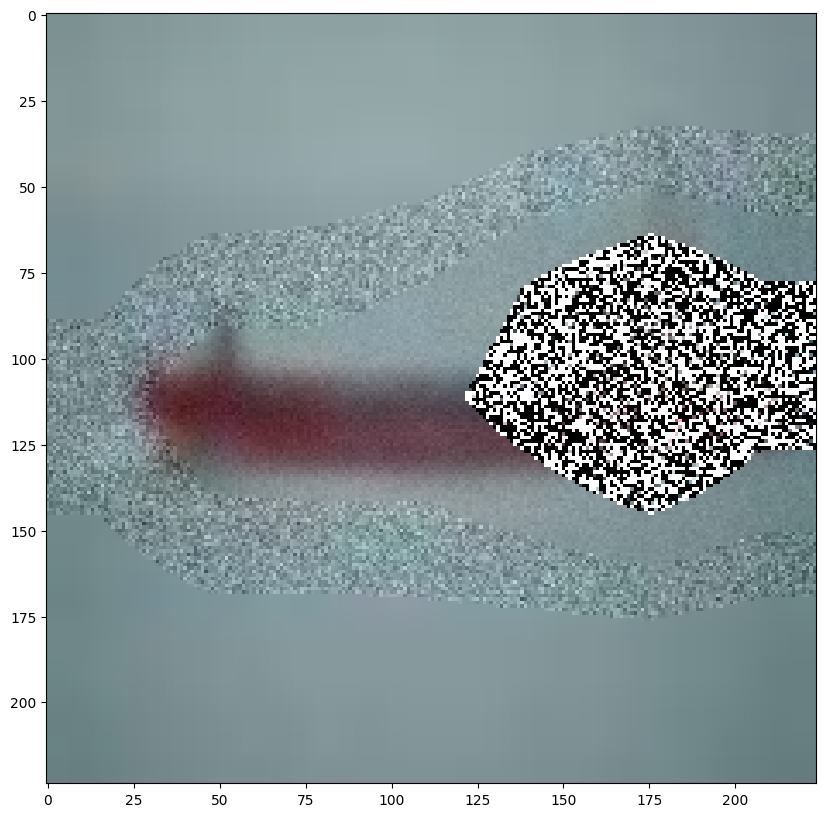

tensor(40107)
tensor(8, device='cuda:0')
tensor([8], device='cuda:0')


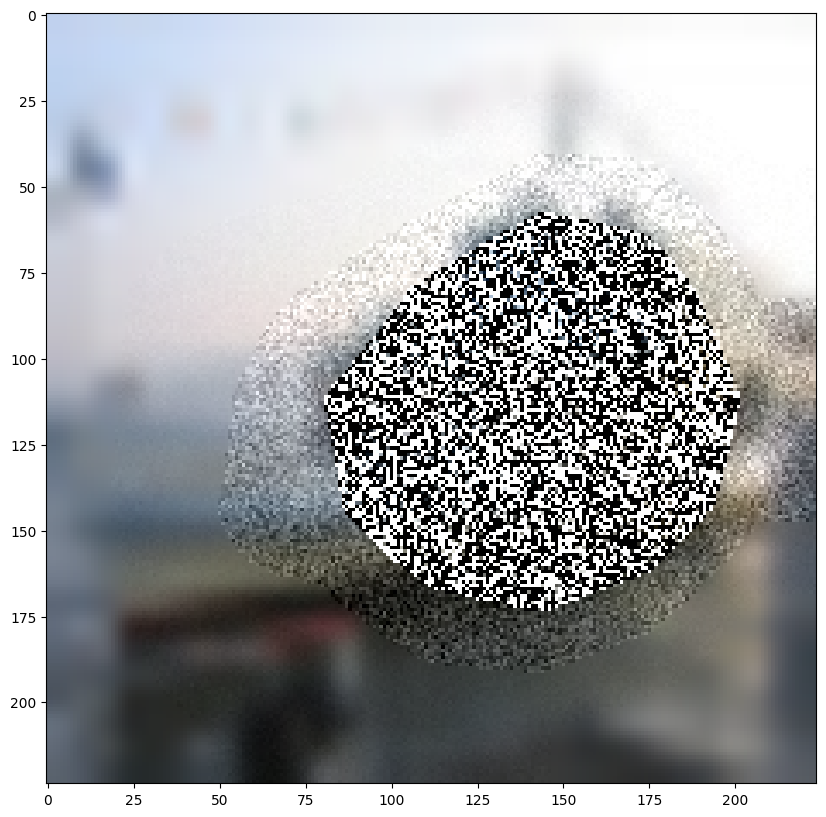

tensor(21161)
tensor(4, device='cuda:0')
tensor([4], device='cuda:0')


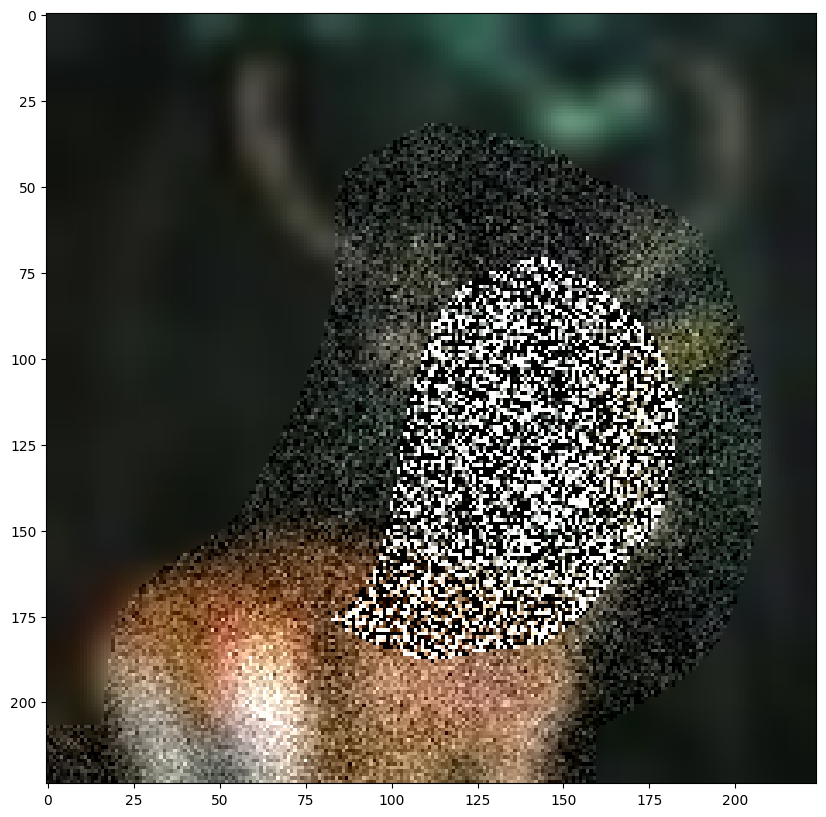

tensor(8305)
tensor(1, device='cuda:0')
tensor([1], device='cuda:0')


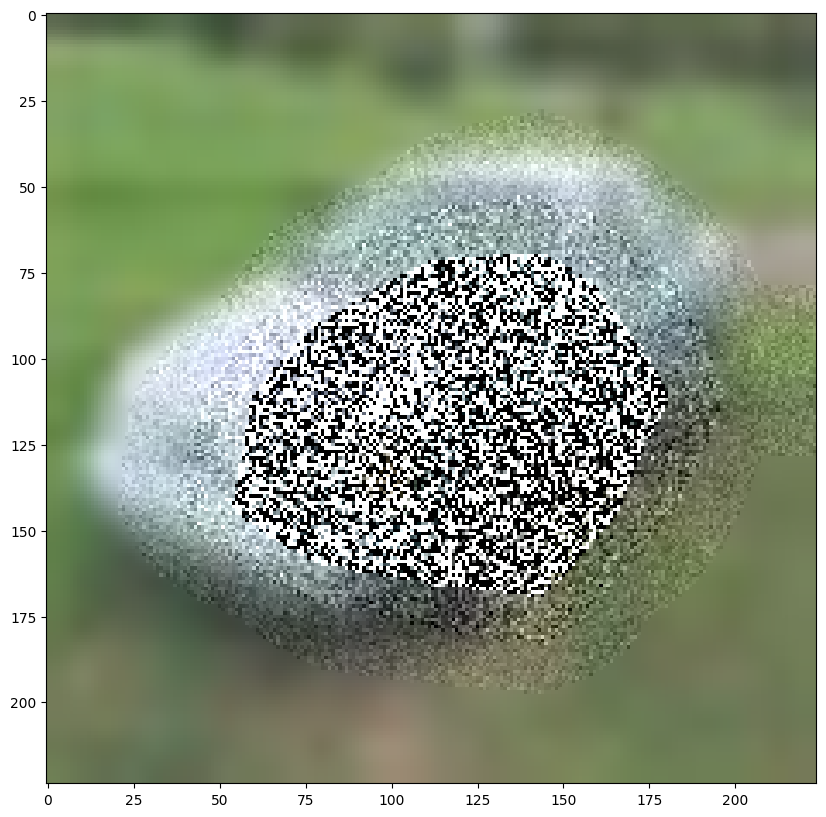

tensor(7050)
tensor(1, device='cuda:0')
tensor([1], device='cuda:0')


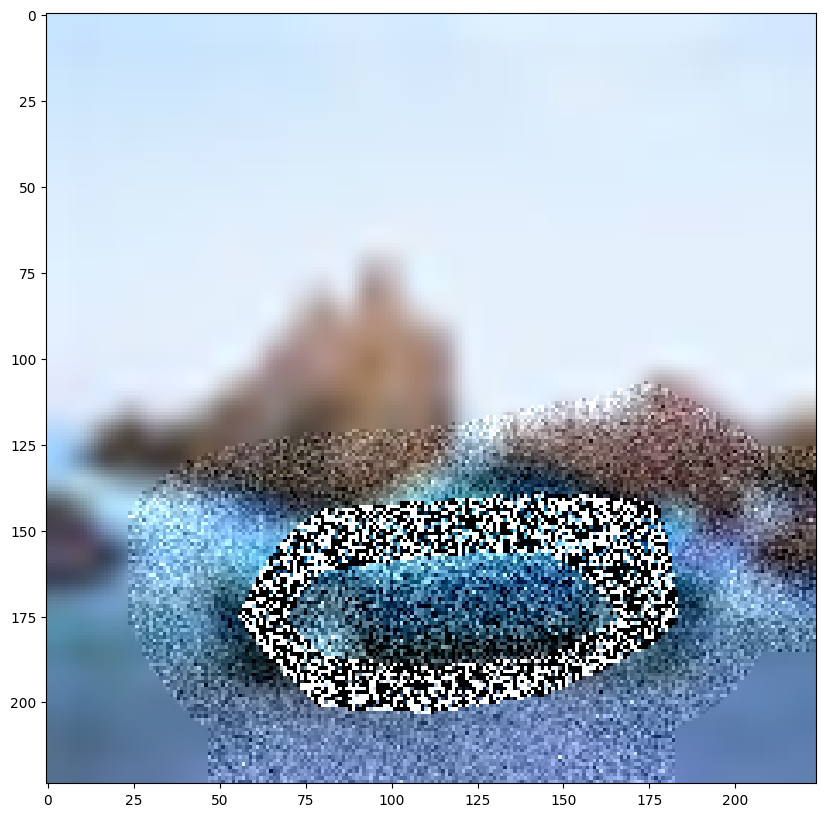

tensor(20148)
tensor(4, device='cuda:0')
tensor([4], device='cuda:0')


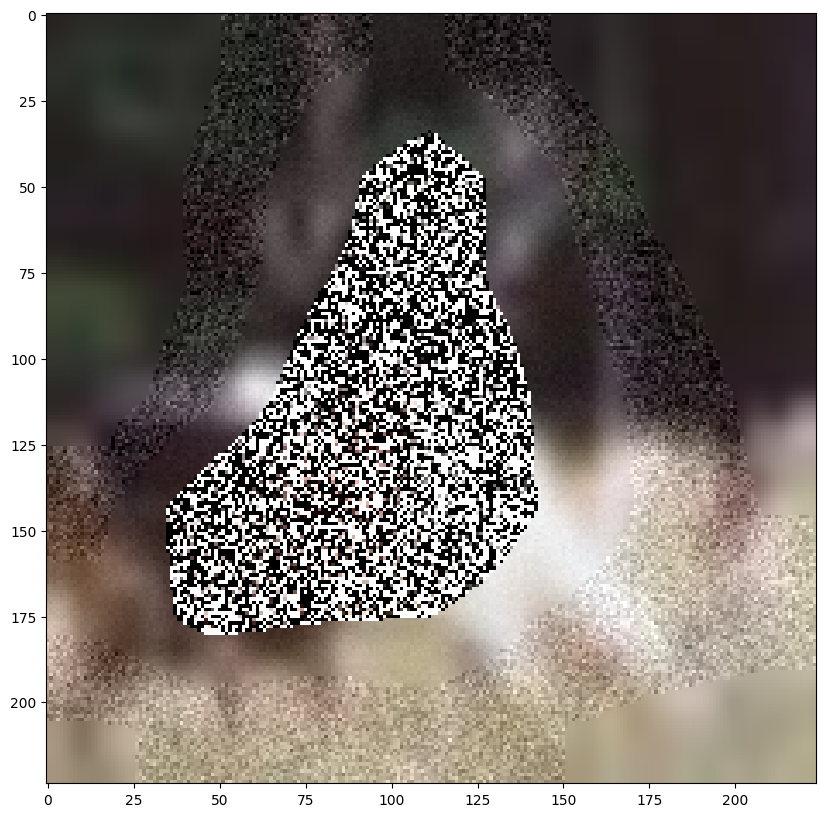

tensor(43495)
tensor(8, device='cuda:0')
tensor([8], device='cuda:0')


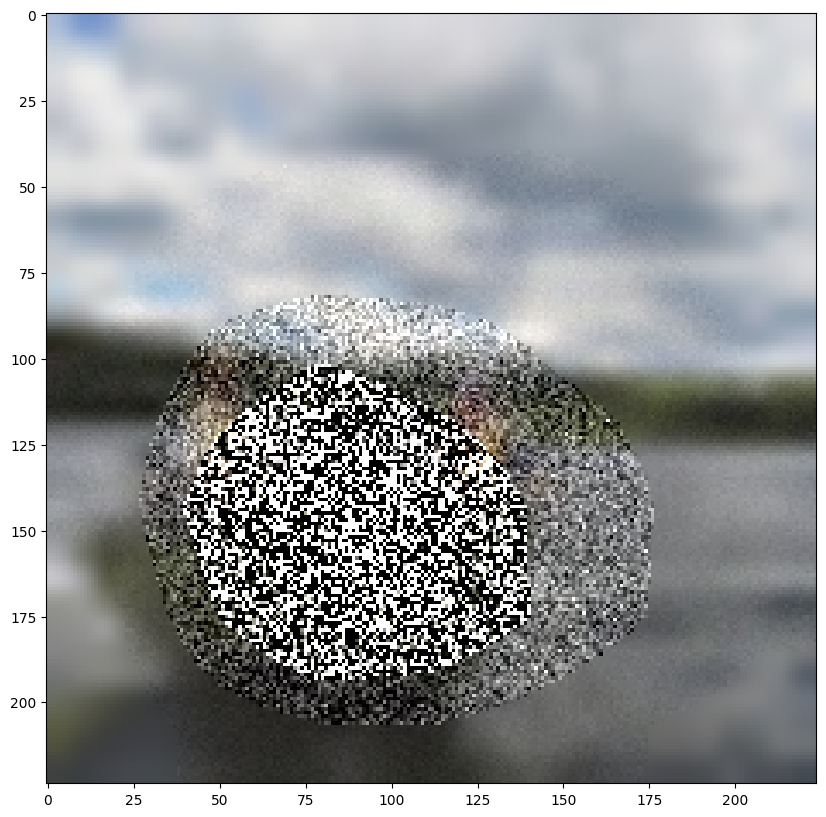

tensor(47944)
tensor(9, device='cuda:0')
tensor([9], device='cuda:0')


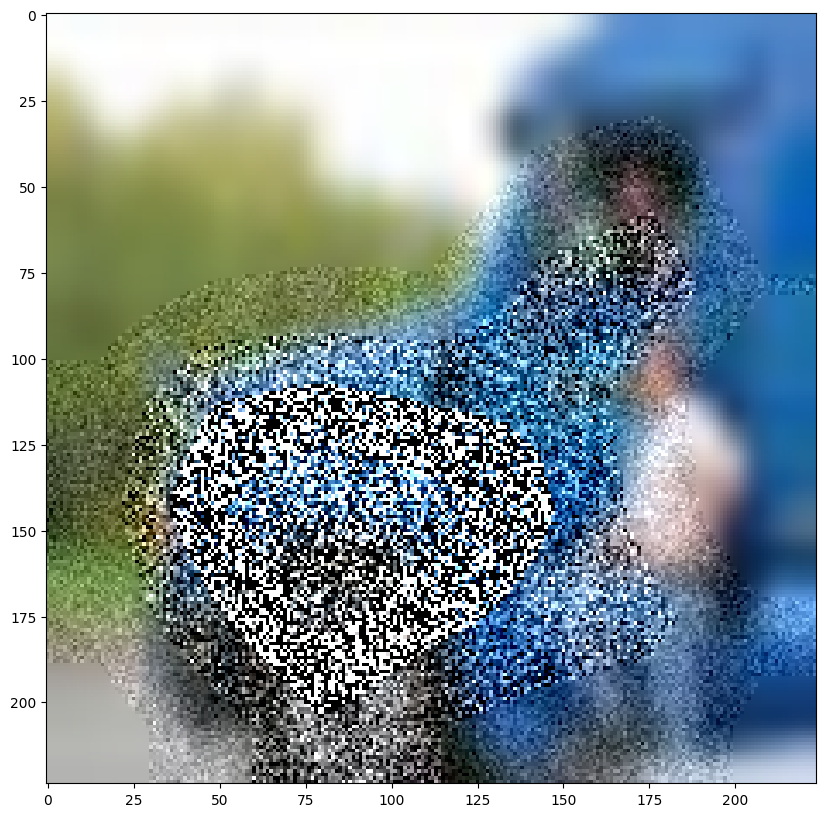

tensor(33825)
tensor(6, device='cuda:0')
tensor([6], device='cuda:0')


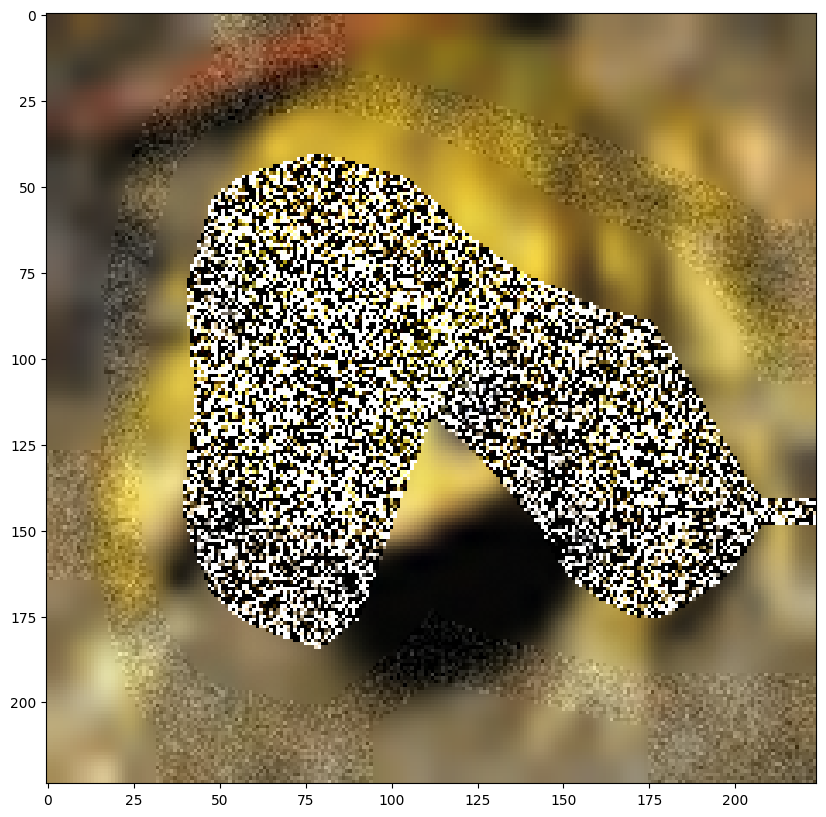

tensor(28679)
tensor(5, device='cuda:0')
tensor([5], device='cuda:0')


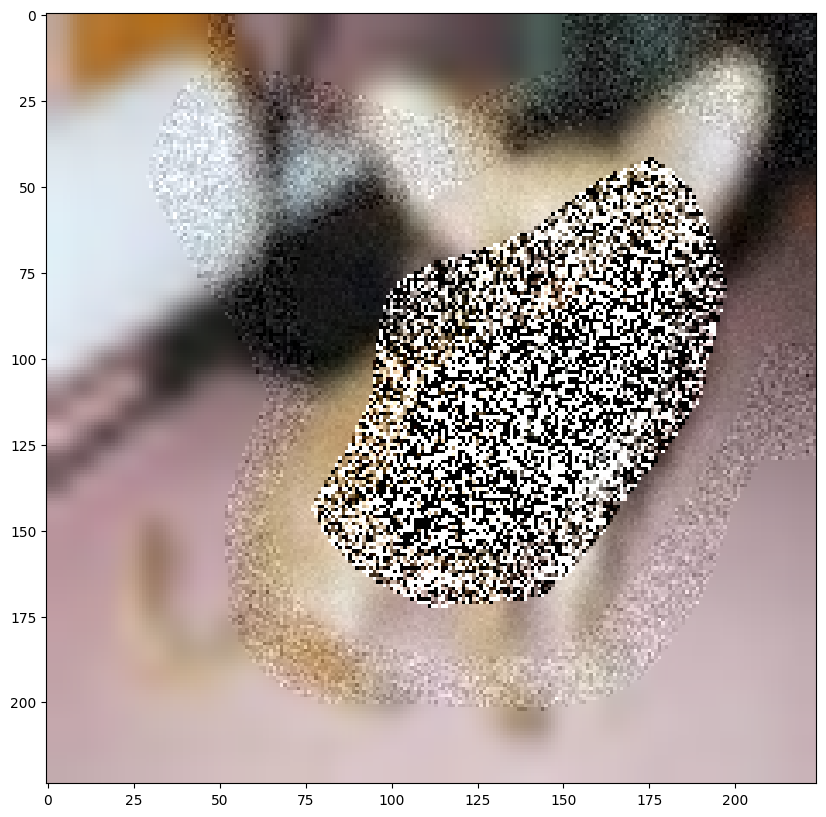

In [18]:
for X,y,index in iter(train_dl):
    X,y = X.to(device),y.to(device)
    normal_X = normal_transform(X).to(device)
    for i in range(10):
        print(index[i])
        print(y[i])
        print(model(normal_X[i:i+1]).argmax(1))
        grayscale_cam = torch.tensor(cv2.imread('./heatmaps/'+str(index[i].item())+'.png', cv2.IMREAD_GRAYSCALE)/255).to(device)
        grayscale_cam-=1
        indices8 = (grayscale_cam < -0.7)
        indices6 = (grayscale_cam < -0.5)
        indices4 = (grayscale_cam < -0.3)
        indices2 = (grayscale_cam < -0.1)
        noise = torch.randn_like(grayscale_cam) * 2
        grayscale_cam[indices2] = noise[indices2] * (torch.randn((1,)).to(device)+1) * 0.025
        grayscale_cam[indices4] = noise[indices4] * (torch.randn((1,)).to(device)+1) * 0.05
        grayscale_cam[indices6] = noise[indices6] * (torch.randn((1,)).to(device)+1) * 1
        grayscale_cam[indices8] = noise[indices8] * (torch.randn((1,)).to(device)+1) * 2
        X[i,:] += grayscale_cam
        X[i] = torch.clamp(X[i],0,1)
        displayImg(X[i].cpu())
    break

In [22]:
class TrainImageFolder(datasets.ImageFolder):  
    def __init__(self, root, transform=None, target_transform=None,  
                 loader=datasets.folder.default_loader,  
                 is_valid_file=None):  
        super(TrainImageFolder, self).__init__(root, transform, target_transform, loader, is_valid_file)  

    def __getitem__(self, index):  
        sample, target = super(TrainImageFolder, self).__getitem__(index)  
        heatmap = self.transform(self.loader('/hy-tmp/heatmaps/'+str(index)+'.png'))
        return sample, target, heatmap

train_ds = TrainImageFolder('mydata/train',
                                transform = train_transform,)
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=get_dataloader_workers())

tensor(9)


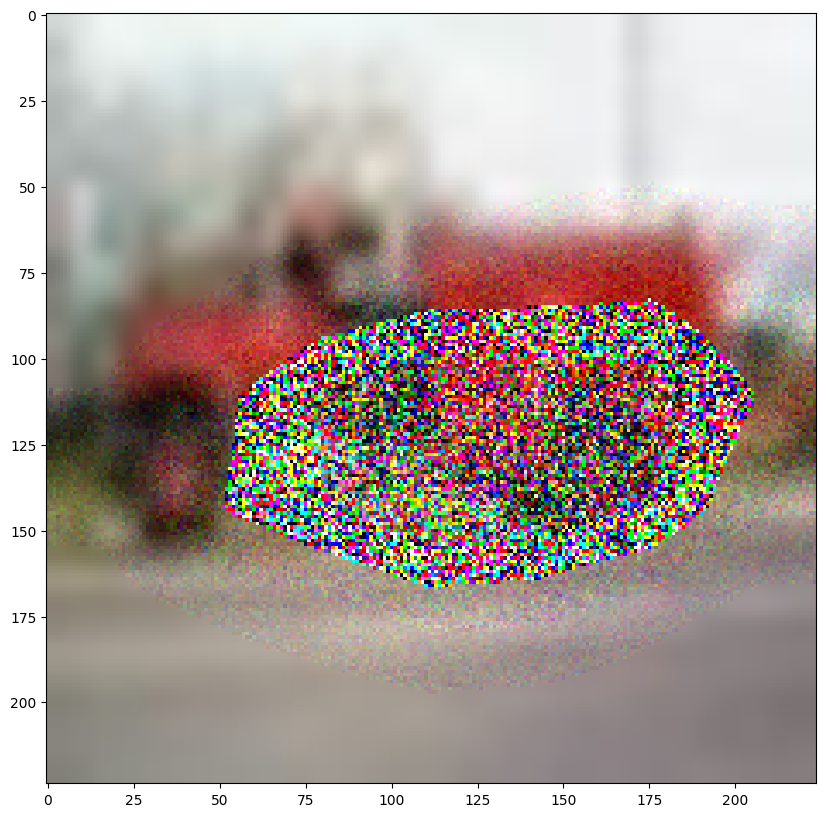

tensor(2)


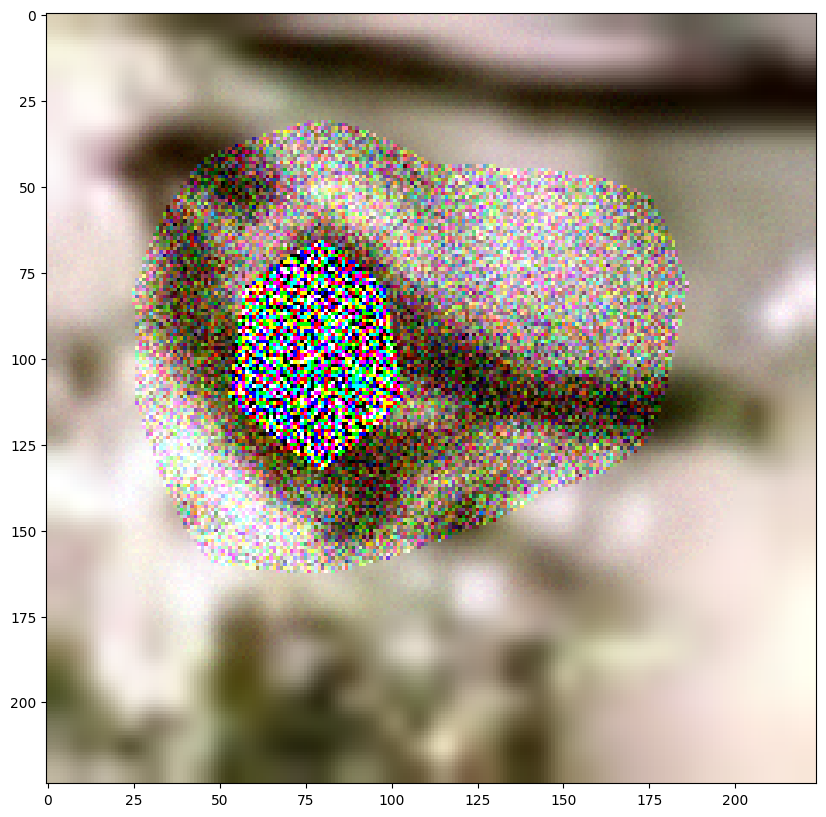

tensor(3)


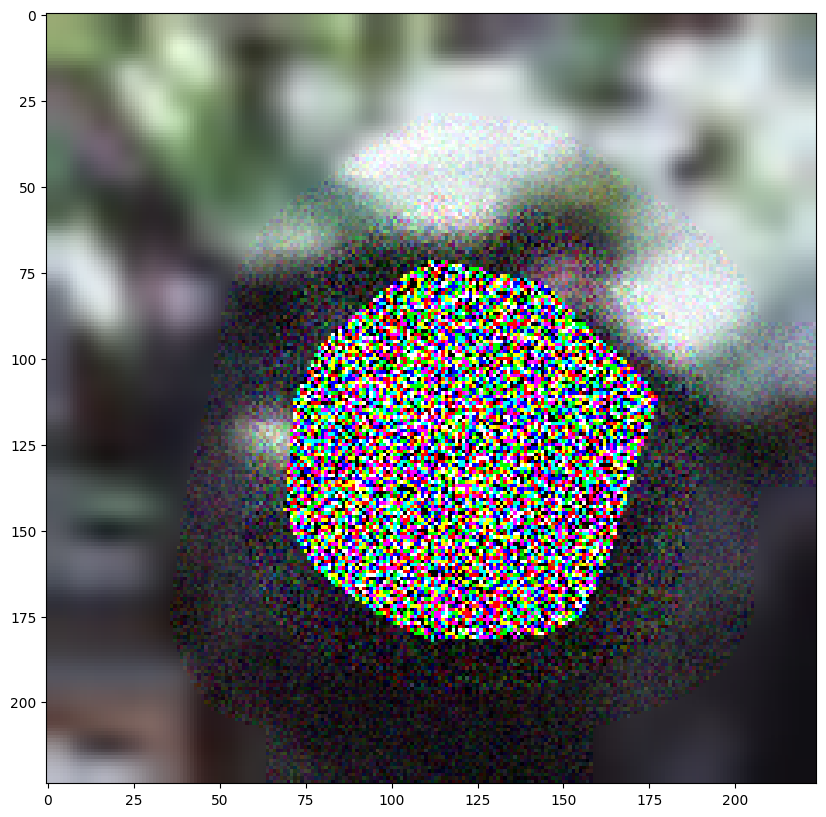

tensor(1)


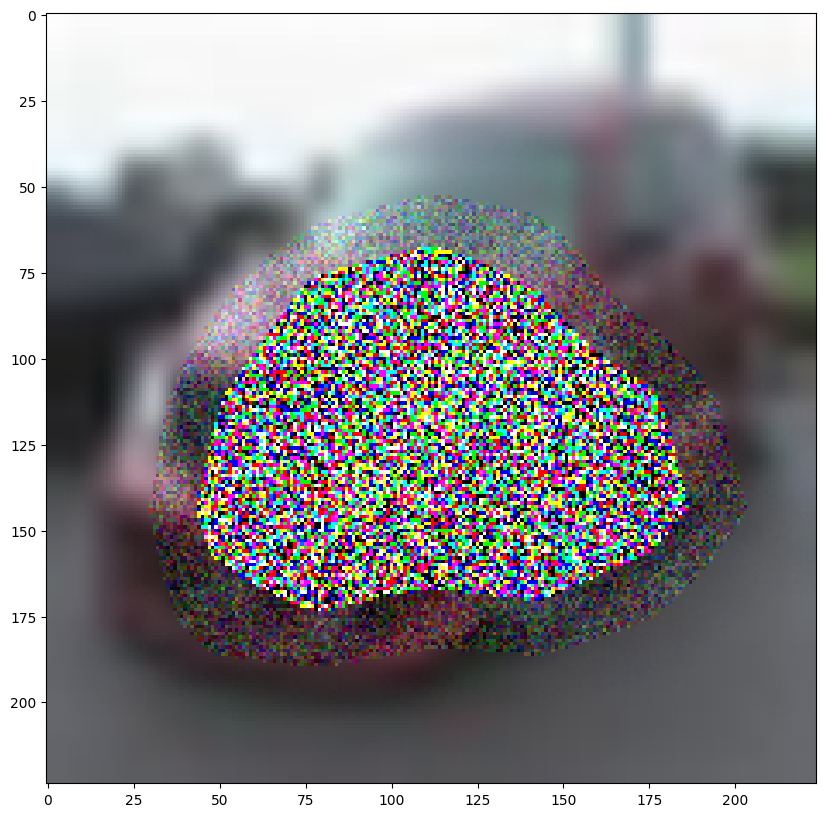

tensor(9)


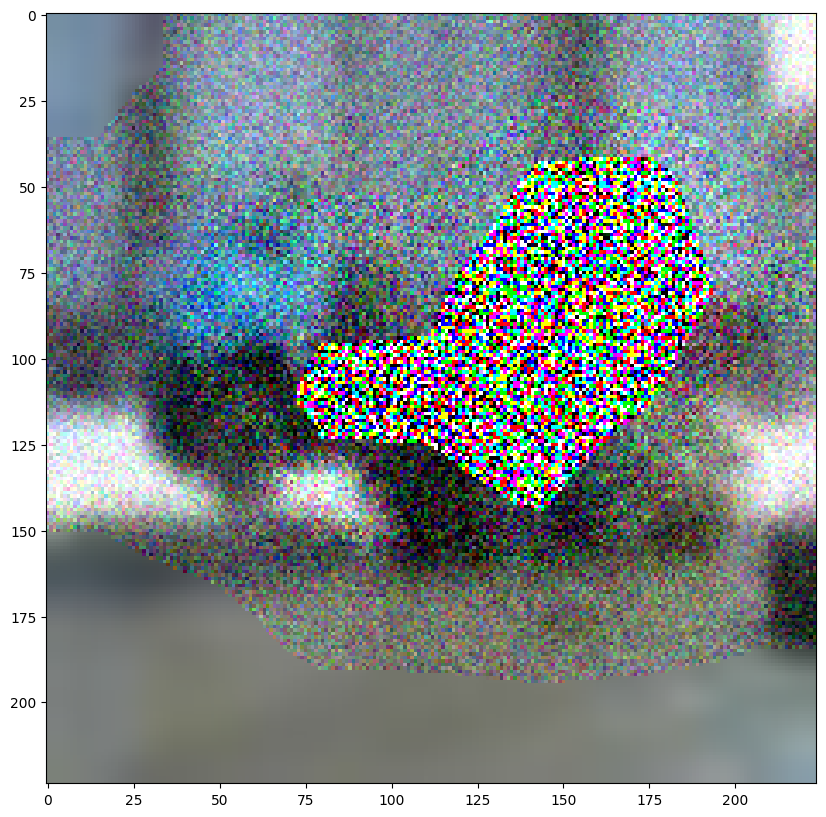

tensor(5)


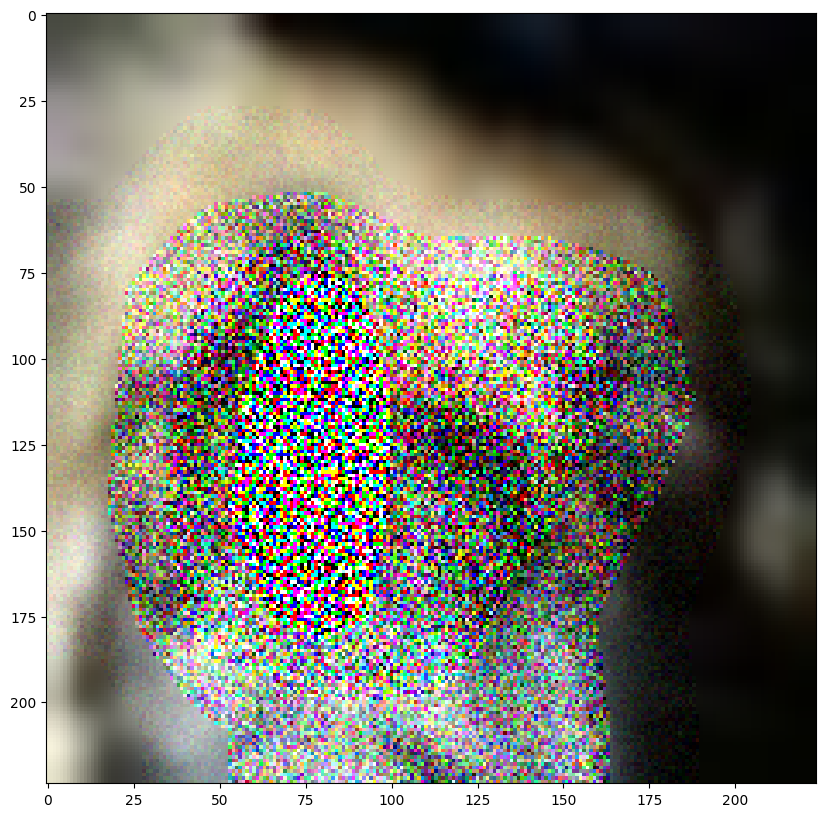

tensor(1)


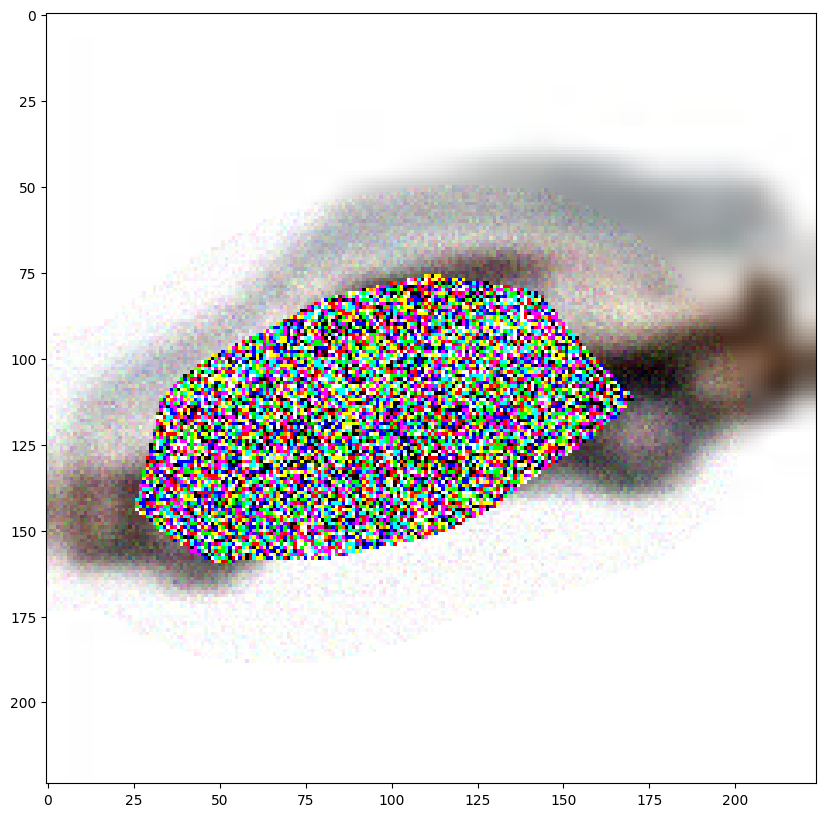

tensor(9)


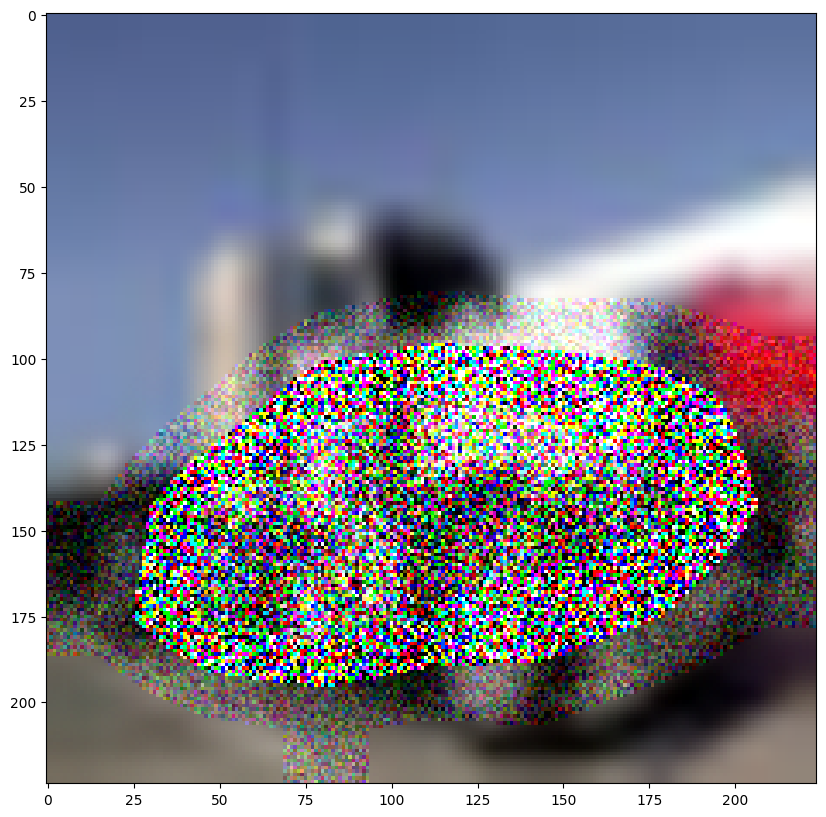

tensor(7)


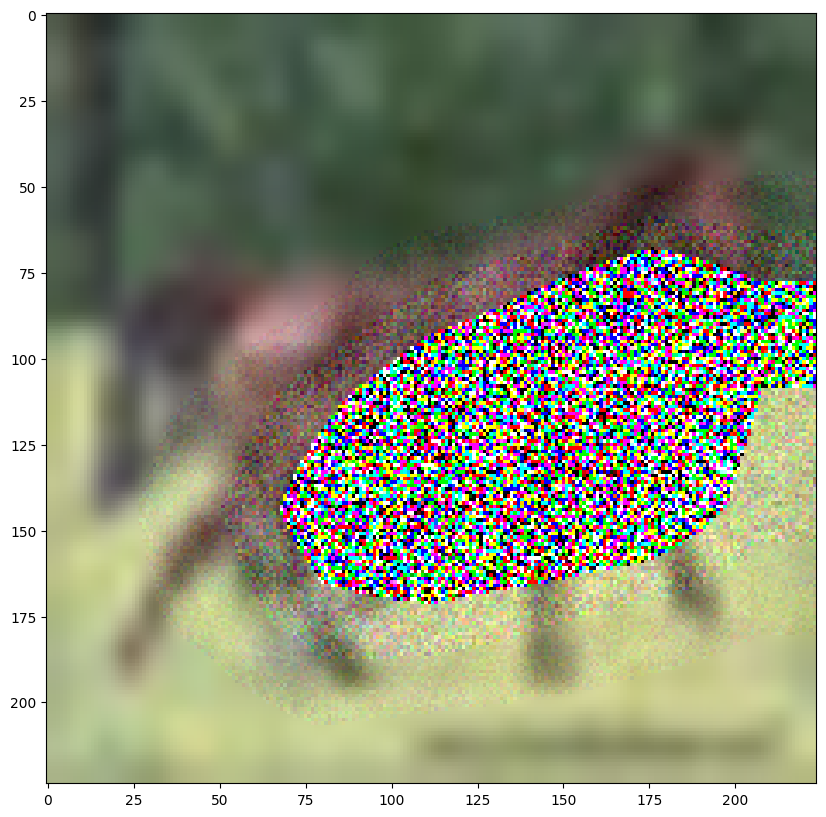

tensor(9)


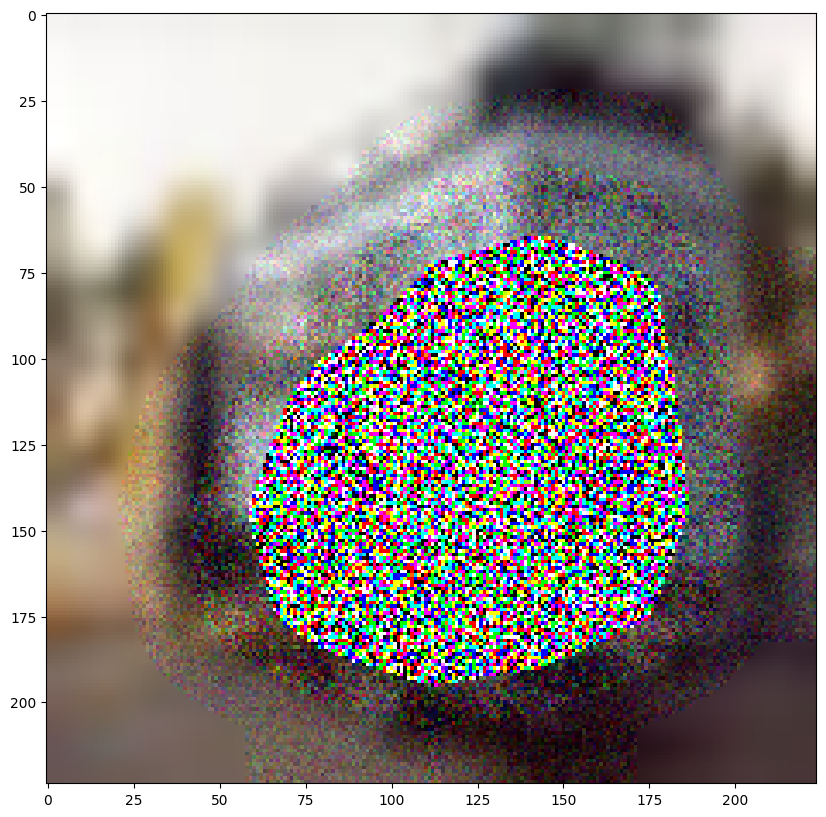

In [24]:
someImages = 0
someLabels = 0
someMasks = 0
i=0
for X,y,M in iter(train_dl):
    someImages=X
    someLabels=y
    someMasks = M
    break

for i in range(0,10):
    print(someLabels[i])
    someMasks[i]-=1
    indices8 = (someMasks[i] < -0.7)
    indices6 = (someMasks[i] < -0.5)
    indices4 = (someMasks[i] < -0.3)
    indices2 = (someMasks[i] < -0.1)
    noise = (torch.randn_like(someMasks[i]) * 2)
    someMasks[i][indices2] = noise[indices2] * (torch.randn((1,))+1) * 0.025
    someMasks[i][indices4] = noise[indices4] * (torch.randn((1,))+1) * 0.05
    someMasks[i][indices6] = noise[indices6] * (torch.randn((1,))+1) * 1
    someMasks[i][indices8] = noise[indices8] * (torch.randn((1,))+1) * 2
    someImages[i,:] += someMasks[i]
    someImages[i] = torch.clamp(someImages[i],0,1)
    displayImg(someImages[i])

In [27]:
def train(dataloader,model,loss_fn,optimizer):
    size = len(dataloader.dataset)
    train_loss = 0
    train_accuracy =0
    model.train()
    for X,y,grayscale_cam in tqdm(dataloader):
        X,y,grayscale_cam = X.to(device), y.to(device), grayscale_cam.to(device)
        for j in range(len(X)):
            grayscale_cam[j]-=1
            indices8 = (grayscale_cam[j] < -0.7)
            indices6 = (grayscale_cam[j] < -0.5)
            indices4 = (grayscale_cam[j] < -0.3)
            indices2 = (grayscale_cam[j] < -0.1)
            noise = (torch.randn_like(grayscale_cam[j]) * 2).to(device)
            grayscale_cam[j][indices2] = noise[indices2] * (torch.randn((1,)).to(device)+1) * 0.025
            grayscale_cam[j][indices4] = noise[indices4] * (torch.randn((1,)).to(device)+1) * 0.05
            grayscale_cam[j][indices6] = noise[indices6] * (torch.randn((1,)).to(device)+1) * 1
            grayscale_cam[j][indices8] = noise[indices8] * (torch.randn((1,)).to(device)+1) * 2
            X[j,:] += grayscale_cam[j]
            X[j] = torch.clamp(X[j],0,1)
        
        X = train_transform2(X)
        # compute prediction
        predict = model(X)
        # compute loss
        loss = loss_fn(predict,y)
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        optimizer.step()
        # record loss
        train_loss += loss.item()
        train_accuracy += (predict.argmax(1) == y).type(torch.float).sum().item()

        
    return train_loss,train_accuracy/size

def test(dataloader,model,loss_fn):
    size = len(dataloader.dataset)
    test_loss = 0
    test_accuracy = 0
    model.eval()
    with torch.no_grad():
        for X,y in tqdm(dataloader):
            X = X.to(device)
            y = y.to(device)
            predict = model(X)
            loss = loss_fn(predict,y)
            test_loss += loss.item()
            test_accuracy += (predict.argmax(1) == y).type(torch.float).sum().item()
            
    return test_loss,test_accuracy/size

In [28]:
epochs = 15
for i in range(epochs):
    print('Epoch,',i)
    train_loss,train_accuracy = train(train_dl,model,loss_fn,optimizer)
    test_loss,test_accuracy = test(test_dl,model,loss_fn)
    print("train_loss:",train_loss,"  train_accuracy:",train_accuracy*100)
    print("test_loss:",test_loss,"  test_accuracy:",test_accuracy*100)
    scheduler.step()

Epoch, 0


100%|██████████| 157/157 [00:06<00:00, 25.09it/s]


train_loss: 510.93878312408924   train_accuracy: 77.496
test_loss: 132.318022755906   test_accuracy: 72.45
Epoch, 1


100%|██████████| 157/157 [00:06<00:00, 24.88it/s]


train_loss: 363.5094505995512   train_accuracy: 83.532
test_loss: 109.6034042686224   test_accuracy: 75.44999999999999
Epoch, 2


100%|██████████| 157/157 [00:06<00:00, 24.72it/s]


train_loss: 315.4736150056124   train_accuracy: 85.784
test_loss: 121.17232602275908   test_accuracy: 74.77000000000001
Epoch, 3


100%|██████████| 157/157 [00:06<00:00, 24.98it/s]


train_loss: 290.68504820764065   train_accuracy: 86.92800000000001
test_loss: 201.02556044608355   test_accuracy: 60.11
Epoch, 4


100%|██████████| 157/157 [00:06<00:00, 24.85it/s]


train_loss: 268.926750279963   train_accuracy: 87.87
test_loss: 115.72982002794743   test_accuracy: 74.76
Epoch, 5


100%|██████████| 157/157 [00:06<00:00, 24.95it/s]


train_loss: 250.1058773547411   train_accuracy: 88.82600000000001
test_loss: 83.91737824678421   test_accuracy: 82.15
Epoch, 6


100%|██████████| 157/157 [00:06<00:00, 24.94it/s]


train_loss: 237.14108272641897   train_accuracy: 89.228
test_loss: 84.26228177547455   test_accuracy: 81.69999999999999
Epoch, 7


100%|██████████| 157/157 [00:06<00:00, 24.56it/s]


train_loss: 227.15570545196533   train_accuracy: 89.732
test_loss: 158.04216058552265   test_accuracy: 63.01
Epoch, 8


100%|██████████| 157/157 [00:06<00:00, 24.81it/s]


train_loss: 217.39911165833473   train_accuracy: 89.96
test_loss: 169.59673576056957   test_accuracy: 60.709999999999994
Epoch, 9


100%|██████████| 157/157 [00:06<00:00, 24.99it/s]


train_loss: 208.1785178333521   train_accuracy: 90.578
test_loss: 74.4273169785738   test_accuracy: 83.44
Epoch, 10


100%|██████████| 157/157 [00:06<00:00, 25.06it/s]


train_loss: 194.1599296554923   train_accuracy: 91.152
test_loss: 182.7174234688282   test_accuracy: 64.36
Epoch, 11


100%|██████████| 157/157 [00:06<00:00, 24.61it/s]


train_loss: 190.12868550792336   train_accuracy: 91.398
test_loss: 120.86639495193958   test_accuracy: 73.9
Epoch, 12


100%|██████████| 157/157 [00:06<00:00, 25.18it/s]


train_loss: 178.32378869503736   train_accuracy: 92.11
test_loss: 105.77276187390089   test_accuracy: 77.03
Epoch, 13


100%|██████████| 157/157 [00:06<00:00, 25.00it/s]


train_loss: 176.37348813563585   train_accuracy: 92.018
test_loss: 141.2275667488575   test_accuracy: 72.18
Epoch, 14


100%|██████████| 157/157 [00:06<00:00, 24.73it/s]

train_loss: 166.12883702665567   train_accuracy: 92.35799999999999
test_loss: 108.63029213249683   test_accuracy: 76.8


In [29]:
epochs = 45
for i in range(epochs):
    print('Epoch,',i)
    train_loss,train_accuracy = train(train_dl,model,loss_fn,optimizer)
    test_loss,test_accuracy = test(test_dl,model,loss_fn)
    print("train_loss:",train_loss,"  train_accuracy:",train_accuracy*100)
    print("test_loss:",test_loss,"  test_accuracy:",test_accuracy*100)
    scheduler.step()

Epoch, 0


100%|██████████| 157/157 [00:06<00:00, 24.30it/s]


train_loss: 163.34494522213936   train_accuracy: 92.582
test_loss: 101.22695914655924   test_accuracy: 77.28
Epoch, 1


100%|██████████| 157/157 [00:06<00:00, 25.11it/s]


train_loss: 156.91003336384892   train_accuracy: 92.838
test_loss: 100.94979679584503   test_accuracy: 78.73
Epoch, 2


100%|██████████| 157/157 [00:06<00:00, 24.92it/s]


train_loss: 155.54146741330624   train_accuracy: 92.92
test_loss: 82.56973874568939   test_accuracy: 81.78999999999999
Epoch, 3


100%|██████████| 157/157 [00:06<00:00, 24.59it/s]


train_loss: 148.13549041748047   train_accuracy: 93.216
test_loss: 93.76585221290588   test_accuracy: 79.65
Epoch, 4


100%|██████████| 157/157 [00:06<00:00, 24.51it/s]


train_loss: 141.0895035546273   train_accuracy: 93.47800000000001
test_loss: 86.82690355181694   test_accuracy: 81.12
Epoch, 5


100%|██████████| 157/157 [00:06<00:00, 24.75it/s]


train_loss: 138.8962711468339   train_accuracy: 93.71000000000001
test_loss: 105.91793216764927   test_accuracy: 76.82
Epoch, 6


100%|██████████| 157/157 [00:06<00:00, 24.61it/s]


train_loss: 132.68689633719623   train_accuracy: 93.85
test_loss: 176.77853918075562   test_accuracy: 65.42999999999999
Epoch, 7


100%|██████████| 157/157 [00:06<00:00, 24.31it/s]


train_loss: 133.06050782091916   train_accuracy: 93.796
test_loss: 107.66222512722015   test_accuracy: 76.11
Epoch, 8


100%|██████████| 157/157 [00:06<00:00, 24.93it/s]


train_loss: 126.74364843778312   train_accuracy: 94.22
test_loss: 116.70460125803947   test_accuracy: 74.37
Epoch, 9


100%|██████████| 157/157 [00:06<00:00, 24.48it/s]


train_loss: 120.82386879809201   train_accuracy: 94.482
test_loss: 104.78303019702435   test_accuracy: 76.07000000000001
Epoch, 10


100%|██████████| 157/157 [00:06<00:00, 24.71it/s]


train_loss: 121.65898333862424   train_accuracy: 94.52000000000001
test_loss: 117.40933966636658   test_accuracy: 74.38
Epoch, 11


100%|██████████| 157/157 [00:06<00:00, 24.81it/s]


train_loss: 114.0681903893128   train_accuracy: 94.806
test_loss: 558.3646068913222   test_accuracy: 42.15
Epoch, 12


100%|██████████| 157/157 [00:06<00:00, 25.13it/s]


train_loss: 112.60208351910114   train_accuracy: 94.838
test_loss: 119.25806434452534   test_accuracy: 74.31
Epoch, 13


100%|██████████| 157/157 [00:06<00:00, 24.72it/s]


train_loss: 107.32993821799755   train_accuracy: 95.004
test_loss: 113.22461023926735   test_accuracy: 76.62
Epoch, 14


100%|██████████| 157/157 [00:06<00:00, 24.71it/s]


train_loss: 107.9192545413971   train_accuracy: 95.04599999999999
test_loss: 113.29544314742088   test_accuracy: 74.98
Epoch, 15


100%|██████████| 157/157 [00:06<00:00, 24.92it/s]


train_loss: 100.37570930924267   train_accuracy: 95.354
test_loss: 104.38922196626663   test_accuracy: 77.77
Epoch, 16


100%|██████████| 157/157 [00:06<00:00, 25.07it/s]


train_loss: 102.10880442522466   train_accuracy: 95.394
test_loss: 158.82041473686695   test_accuracy: 71.32
Epoch, 17


100%|██████████| 157/157 [00:06<00:00, 25.07it/s]


train_loss: 98.10151500161737   train_accuracy: 95.634
test_loss: 149.11006362736225   test_accuracy: 70.02000000000001
Epoch, 18


100%|██████████| 157/157 [00:06<00:00, 24.98it/s]


train_loss: 94.77135838661343   train_accuracy: 95.636
test_loss: 123.78339751064777   test_accuracy: 75.42999999999999
Epoch, 19


100%|██████████| 157/157 [00:06<00:00, 23.87it/s]


train_loss: 89.74240189883858   train_accuracy: 95.85000000000001
test_loss: 129.4222735762596   test_accuracy: 74.59
Epoch, 20


100%|██████████| 157/157 [00:06<00:00, 24.51it/s]


train_loss: 89.581737219356   train_accuracy: 95.818
test_loss: 167.62890080735087   test_accuracy: 66.67999999999999
Epoch, 21


100%|██████████| 157/157 [00:06<00:00, 24.78it/s]


train_loss: 86.25977117940784   train_accuracy: 96.092
test_loss: 102.0860480889678   test_accuracy: 77.83
Epoch, 22


100%|██████████| 157/157 [00:06<00:00, 23.95it/s]


train_loss: 82.94522441551089   train_accuracy: 96.206
test_loss: 140.51647973805666   test_accuracy: 72.96000000000001
Epoch, 23


100%|██████████| 157/157 [00:06<00:00, 24.18it/s]


train_loss: 79.83455257164314   train_accuracy: 96.38799999999999
test_loss: 132.19877329468727   test_accuracy: 73.29
Epoch, 24


100%|██████████| 157/157 [00:06<00:00, 24.60it/s]


train_loss: 80.49677708372474   train_accuracy: 96.258
test_loss: 109.30820106714964   test_accuracy: 79.51
Epoch, 25


100%|██████████| 157/157 [00:06<00:00, 24.65it/s]


train_loss: 76.54412330826744   train_accuracy: 96.47200000000001
test_loss: 136.25532046705484   test_accuracy: 72.82
Epoch, 26


100%|██████████| 157/157 [00:06<00:00, 24.39it/s]


train_loss: 76.64558692742139   train_accuracy: 96.478
test_loss: 181.31035609543324   test_accuracy: 64.64999999999999
Epoch, 27


100%|██████████| 157/157 [00:06<00:00, 24.49it/s]


train_loss: 74.73763309884816   train_accuracy: 96.682
test_loss: 123.57209583744407   test_accuracy: 75.78
Epoch, 28


100%|██████████| 157/157 [00:06<00:00, 24.82it/s]


train_loss: 71.76806413847953   train_accuracy: 96.734
test_loss: 115.78813071548939   test_accuracy: 75.8
Epoch, 29


100%|██████████| 157/157 [00:06<00:00, 24.76it/s]


train_loss: 71.28880526917055   train_accuracy: 96.696
test_loss: 117.8894007652998   test_accuracy: 76.02
Epoch, 30


100%|██████████| 157/157 [00:06<00:00, 24.73it/s]


train_loss: 68.91242998465896   train_accuracy: 96.814
test_loss: 131.7661437485367   test_accuracy: 74.8
Epoch, 31


100%|██████████| 157/157 [00:06<00:00, 24.20it/s]


train_loss: 65.15468977764249   train_accuracy: 97.05799999999999
test_loss: 177.9215911924839   test_accuracy: 68.41000000000001
Epoch, 32


100%|██████████| 157/157 [00:06<00:00, 24.74it/s]


train_loss: 66.39352539554238   train_accuracy: 96.966
test_loss: 140.2024999409914   test_accuracy: 72.45
Epoch, 33


100%|██████████| 157/157 [00:06<00:00, 24.73it/s]


train_loss: 66.03634089510888   train_accuracy: 97.08200000000001
test_loss: 130.043605402112   test_accuracy: 74.29
Epoch, 34


100%|██████████| 157/157 [00:06<00:00, 24.54it/s]


train_loss: 64.86949795437977   train_accuracy: 97.044
test_loss: 112.95087726414204   test_accuracy: 78.03999999999999
Epoch, 35


100%|██████████| 157/157 [00:06<00:00, 24.86it/s]


train_loss: 60.56839332613163   train_accuracy: 97.232
test_loss: 125.96079643815756   test_accuracy: 75.21
Epoch, 36


100%|██████████| 157/157 [00:06<00:00, 24.82it/s]


train_loss: 61.65127691347152   train_accuracy: 97.174
test_loss: 133.71591274440289   test_accuracy: 76.24
Epoch, 37


100%|██████████| 157/157 [00:06<00:00, 24.41it/s]


train_loss: 59.80158393410966   train_accuracy: 97.194
test_loss: 142.06634801626205   test_accuracy: 74.63
Epoch, 38


100%|██████████| 157/157 [00:06<00:00, 24.60it/s]


train_loss: 56.89931804174557   train_accuracy: 97.392
test_loss: 155.3068460226059   test_accuracy: 71.22
Epoch, 39


100%|██████████| 157/157 [00:06<00:00, 25.01it/s]


train_loss: 55.70300582656637   train_accuracy: 97.38
test_loss: 148.85781437158585   test_accuracy: 72.14
Epoch, 40


100%|██████████| 157/157 [00:06<00:00, 24.44it/s]


train_loss: 55.28663181094453   train_accuracy: 97.504
test_loss: 135.15174588933587   test_accuracy: 73.14
Epoch, 41


100%|██████████| 157/157 [00:06<00:00, 24.62it/s]


train_loss: 51.8169934572652   train_accuracy: 97.66
test_loss: 225.70048061013222   test_accuracy: 59.58
Epoch, 42


100%|██████████| 157/157 [00:06<00:00, 24.19it/s]


train_loss: 52.65468892571516   train_accuracy: 97.646
test_loss: 142.73776514828205   test_accuracy: 71.39999999999999
Epoch, 43


100%|██████████| 157/157 [00:06<00:00, 24.83it/s]


train_loss: 54.49712806311436   train_accuracy: 97.516
test_loss: 177.08787813037634   test_accuracy: 66.59
Epoch, 44


100%|██████████| 157/157 [00:06<00:00, 24.55it/s]

train_loss: 53.52632990013808   train_accuracy: 97.52
test_loss: 144.48252475261688   test_accuracy: 71.77


In [30]:
def train(dataloader,model,loss_fn,optimizer):
    size = len(dataloader.dataset)
    train_loss = 0
    train_accuracy =0
    model.train()
    for X,y,index in tqdm(dataloader):
        X,y = X.to(device), y.to(device)
        X = train_transform2(X)
        # compute prediction
        predict = model(X)
        # compute loss
        loss = loss_fn(predict,y)
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        optimizer.step()
        # record loss
        train_loss += loss.item()
        train_accuracy += (predict.argmax(1) == y).type(torch.float).sum().item()  
    return train_loss,train_accuracy/size

def test(dataloader,model,loss_fn):
    size = len(dataloader.dataset)
    test_loss = 0
    test_accuracy = 0
    model.eval()
    with torch.no_grad():
        for X,y in tqdm(dataloader):
            X = X.to(device)
            y = y.to(device)
            predict = model(X)
            loss = loss_fn(predict,y)
            test_loss += loss.item()
            test_accuracy += (predict.argmax(1) == y).type(torch.float).sum().item()
            
    return test_loss,test_accuracy/size

train_ds = MyImageFolder('mydata/train',
                                transform = train_transform,)
test_ds = datasets.ImageFolder('mydata/test',
                                transform = test_transform,)

In [31]:
epochs = 15
for i in range(epochs):
    print('Epoch,',i)
    train_loss,train_accuracy = train(train_dl,model,loss_fn,optimizer)
    test_loss,test_accuracy = test(test_dl,model,loss_fn)
    print("train_loss:",train_loss,"  train_accuracy:",train_accuracy*100)
    print("test_loss:",test_loss,"  test_accuracy:",test_accuracy*100)
    scheduler.step()

Epoch, 0


100%|██████████| 157/157 [00:06<00:00, 24.15it/s]


train_loss: 76.14134827349335   train_accuracy: 96.58200000000001
test_loss: 63.381962690502405   test_accuracy: 89.73
Epoch, 1


100%|██████████| 157/157 [00:06<00:00, 24.63it/s]


train_loss: 50.49362533958629   train_accuracy: 97.76599999999999
test_loss: 63.44080279674381   test_accuracy: 90.3
Epoch, 2


100%|██████████| 157/157 [00:06<00:00, 23.91it/s]


train_loss: 40.219343151315115   train_accuracy: 98.166
test_loss: 63.97094576759264   test_accuracy: 90.25
Epoch, 3


100%|██████████| 157/157 [00:06<00:00, 24.85it/s]


train_loss: 35.4116541731637   train_accuracy: 98.428
test_loss: 98.18288305122405   test_accuracy: 86.79
Epoch, 4


100%|██████████| 157/157 [00:06<00:00, 24.93it/s]


train_loss: 32.42461771168746   train_accuracy: 98.536
test_loss: 55.98157195630483   test_accuracy: 91.29
Epoch, 5


100%|██████████| 157/157 [00:06<00:00, 24.43it/s]


train_loss: 28.67731772811385   train_accuracy: 98.778
test_loss: 65.79763443954289   test_accuracy: 90.42
Epoch, 6


100%|██████████| 157/157 [00:06<00:00, 25.21it/s]


train_loss: 25.742172227677656   train_accuracy: 98.856
test_loss: 60.65098266955465   test_accuracy: 90.96
Epoch, 7


100%|██████████| 157/157 [00:06<00:00, 24.63it/s]


train_loss: 20.98778251610929   train_accuracy: 99.116
test_loss: 69.98217507638037   test_accuracy: 90.05
Epoch, 8


100%|██████████| 157/157 [00:06<00:00, 24.88it/s]


train_loss: 19.326386890141293   train_accuracy: 99.168
test_loss: 65.26963548641652   test_accuracy: 90.73
Epoch, 9


100%|██████████| 157/157 [00:06<00:00, 24.23it/s]


train_loss: 18.345622978929896   train_accuracy: 99.224
test_loss: 88.8500198237598   test_accuracy: 88.07000000000001
Epoch, 10


100%|██████████| 157/157 [00:06<00:00, 24.78it/s]


train_loss: 17.952721562731313   train_accuracy: 99.22800000000001
test_loss: 63.572079537436366   test_accuracy: 90.95
Epoch, 11


100%|██████████| 157/157 [00:06<00:00, 24.76it/s]


train_loss: 17.14896149659762   train_accuracy: 99.21799999999999
test_loss: 64.47731243283488   test_accuracy: 91.05
Epoch, 12


100%|██████████| 157/157 [00:06<00:00, 24.54it/s]


train_loss: 15.310126442283945   train_accuracy: 99.35199999999999
test_loss: 56.95445353834657   test_accuracy: 91.95
Epoch, 13


100%|██████████| 157/157 [00:06<00:00, 24.15it/s]


train_loss: 16.156674869038397   train_accuracy: 99.336
test_loss: 61.42383288153087   test_accuracy: 91.60000000000001
Epoch, 14


100%|██████████| 157/157 [00:06<00:00, 24.94it/s]

train_loss: 12.989334785699612   train_accuracy: 99.47399999999999
test_loss: 65.35502626933157   test_accuracy: 91.25999999999999


In [32]:
epochs = 15
for i in range(epochs):
    print('Epoch,',i)
    train_loss,train_accuracy = train(train_dl,model,loss_fn,optimizer)
    test_loss,test_accuracy = test(test_dl,model,loss_fn)
    print("train_loss:",train_loss,"  train_accuracy:",train_accuracy*100)
    print("test_loss:",test_loss,"  test_accuracy:",test_accuracy*100)
    scheduler.step()

Epoch, 0


100%|██████████| 157/157 [00:06<00:00, 24.46it/s]


train_loss: 13.996784899150953   train_accuracy: 99.394
test_loss: 58.10324886906892   test_accuracy: 92.05
Epoch, 1


100%|██████████| 157/157 [00:06<00:00, 24.36it/s]


train_loss: 12.301594608929008   train_accuracy: 99.484
test_loss: 64.50994271691889   test_accuracy: 91.60000000000001
Epoch, 2


100%|██████████| 157/157 [00:06<00:00, 24.51it/s]


train_loss: 12.284729935752694   train_accuracy: 99.514
test_loss: 58.5959085538052   test_accuracy: 91.99000000000001
Epoch, 3


100%|██████████| 157/157 [00:06<00:00, 24.81it/s]


train_loss: 10.481572792632505   train_accuracy: 99.55000000000001
test_loss: 61.75044576008804   test_accuracy: 92.12
Epoch, 4


100%|██████████| 157/157 [00:06<00:00, 24.29it/s]


train_loss: 10.379877885992755   train_accuracy: 99.58399999999999
test_loss: 62.04474881431088   test_accuracy: 91.7
Epoch, 5


100%|██████████| 157/157 [00:06<00:00, 24.37it/s]


train_loss: 8.657901802333072   train_accuracy: 99.652
test_loss: 57.82781771826558   test_accuracy: 92.39
Epoch, 6


100%|██████████| 157/157 [00:06<00:00, 24.63it/s]


train_loss: 8.701788904349087   train_accuracy: 99.666
test_loss: 58.78404338657856   test_accuracy: 92.27
Epoch, 7


100%|██████████| 157/157 [00:06<00:00, 24.86it/s]


train_loss: 8.466169873870967   train_accuracy: 99.652
test_loss: 69.19171434396412   test_accuracy: 91.3
Epoch, 8


100%|██████████| 157/157 [00:06<00:00, 24.07it/s]


train_loss: 7.724388223403366   train_accuracy: 99.732
test_loss: 77.1194138333667   test_accuracy: 90.41
Epoch, 9


100%|██████████| 157/157 [00:06<00:00, 24.86it/s]


train_loss: 8.489022176829167   train_accuracy: 99.67
test_loss: 72.21802485734224   test_accuracy: 91.03
Epoch, 10


100%|██████████| 157/157 [00:06<00:00, 24.43it/s]


train_loss: 7.563257661648095   train_accuracy: 99.712
test_loss: 68.17457947134972   test_accuracy: 91.39
Epoch, 11


100%|██████████| 157/157 [00:06<00:00, 24.56it/s]


train_loss: 7.514765890518902   train_accuracy: 99.68
test_loss: 63.860086844302714   test_accuracy: 92.04
Epoch, 12


100%|██████████| 157/157 [00:06<00:00, 24.64it/s]


train_loss: 5.930137887327874   train_accuracy: 99.78
test_loss: 65.20131899695843   test_accuracy: 92.01
Epoch, 13


100%|██████████| 157/157 [00:06<00:00, 24.78it/s]


train_loss: 6.40543176423671   train_accuracy: 99.756
test_loss: 65.33739351434633   test_accuracy: 91.97
Epoch, 14


100%|██████████| 157/157 [00:06<00:00, 24.61it/s]

train_loss: 6.335369125059515   train_accuracy: 99.74
test_loss: 65.0207057222724   test_accuracy: 92.02
